In [470]:
import pandas as pd
import os 
from os.path import join
from sklearn.cluster import KMeans
import numpy as np
import pylab as plt
import warnings
from matplotlib.collections import LineCollection


def colored_line(x, y, c, ax, **lc_kwargs):
    """
    Plot a line with a color specified along the line by a third value.

    It does this by creating a collection of line segments. Each line segment is
    made up of two straight lines each connecting the current (x, y) point to the
    midpoints of the lines connecting the current point with its two neighbors.
    This creates a smooth line with no gaps between the line segments.

    Parameters
    ----------
    x, y : array-like
        The horizontal and vertical coordinates of the data points.
    c : array-like
        The color values, which should be the same size as x and y.
    ax : Axes
        Axis object on which to plot the colored line.
    **lc_kwargs
        Any additional arguments to pass to matplotlib.collections.LineCollection
        constructor. This should not include the array keyword argument because
        that is set to the color argument. If provided, it will be overridden.

    Returns
    -------
    matplotlib.collections.LineCollection
        The generated line collection representing the colored line.
    """
    if "array" in lc_kwargs:
        warnings.warn('The provided "array" keyword argument will be overridden')

    # Default the capstyle to butt so that the line segments smoothly line up
    default_kwargs = {"capstyle": "butt"}
    default_kwargs.update(lc_kwargs)

    # Compute the midpoints of the line segments. Include the first and last points
    # twice so we don't need any special syntax later to handle them.
    x = np.asarray(x)
    y = np.asarray(y)
    x_midpts = np.hstack((x[0], 0.5 * (x[1:] + x[:-1]), x[-1]))
    y_midpts = np.hstack((y[0], 0.5 * (y[1:] + y[:-1]), y[-1]))

    # Determine the start, middle, and end coordinate pair of each line segment.
    # Use the reshape to add an extra dimension so each pair of points is in its
    # own list. Then concatenate them to create:
    # [
    #   [(x1_start, y1_start), (x1_mid, y1_mid), (x1_end, y1_end)],
    #   [(x2_start, y2_start), (x2_mid, y2_mid), (x2_end, y2_end)],
    #   ...
    # ]
    coord_start = np.column_stack((x_midpts[:-1], y_midpts[:-1]))[:, np.newaxis, :]
    coord_mid = np.column_stack((x, y))[:, np.newaxis, :]
    coord_end = np.column_stack((x_midpts[1:], y_midpts[1:]))[:, np.newaxis, :]
    segments = np.concatenate((coord_start, coord_mid, coord_end), axis=1)

    lc = LineCollection(segments, **default_kwargs)
    lc.set_array(c)  # set the colors of each segment

    return ax.add_collection(lc)

In [472]:
loads = pd.read_csv(join(os.getcwd(), '..', 'inputs', 'loads.csv'))

# Pick one week of data for each period 
period = 24*7

# Split loads into 52 weeks for clustering
X = np.array([loads.iloc[:,i:i+period].values.flatten() 
     for i in range(1, 8760-period+2, period)])

In [474]:
# Run K-Means clustering with 100 initializations
kmeans_2 = KMeans(n_clusters=2, random_state=0, n_init=100).fit(X)
kmeans_6 = KMeans(n_clusters=6, random_state=0, n_init=100).fit(X)

In [475]:
def plot_clusters(kmeans):
    '''
    Plot year of loads coloring each clustered week
    '''
    
    tmax = 8760-(8760%period)

    x = np.linspace(0, 52, tmax)
    y = loads.sum(axis=0).iloc[1:].values[0:tmax]
    c = np.repeat(kmeans.labels_, 24*7)
    
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=c, cmap='Set2', s=0)
    colored_line(x, y, c=c, ax=ax, cmap='Set2', alpha=0.75)
    plt.xlabel("Week")
    plt.ylabel("Load (MW)")

In [457]:
# Get representative weeks with the smallest mean squared error
# to the K-Means center. Also determine the number of weeks/weight of each.

df = pd.DataFrame(X)
df['cluster'] = kmeans.labels_

representative_period = []
weight = []
for i in range(2):
    error = df[df['cluster'] == i].iloc[:, 0:-1] - kmeans_2.cluster_centers_[i]
    mse = (error**2).sum(axis=1)
    idx_min = np.argmin(mse)
    representative_period.append(error.index[idx_min])
    weight.append(len(mse))

In [476]:
list(tuple(zip(representative_period, weight)))

[(18, 38), (31, 14)]

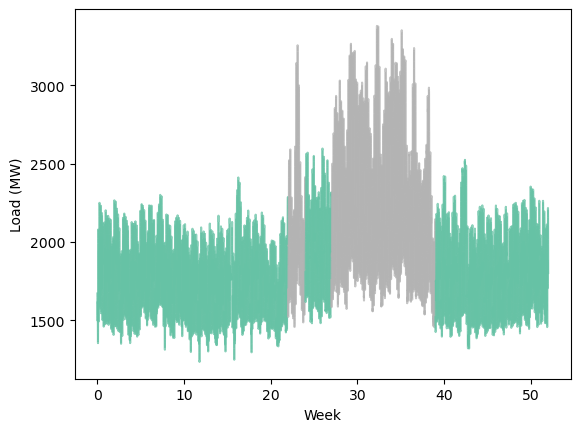

In [481]:
# For trackability will just work with two representative weeks
plot_clusters(kmeans_2)

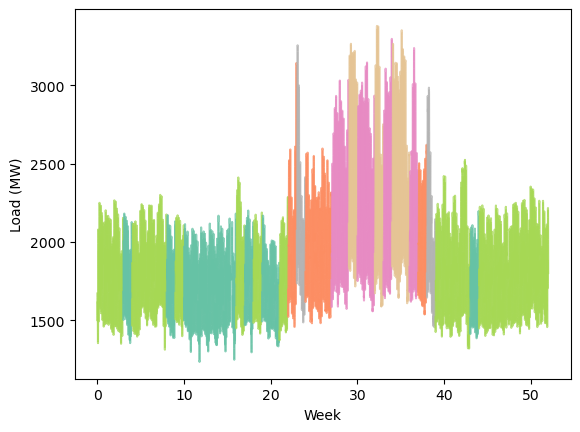

In [483]:
# 6 weeks would be ideal
plot_clusters(kmeans_6)